# AutoEncoder 

In the following we will show you how to create, train and use a simple autoencoder. We will then show you how to make an auto-encoder more robust against noise. 

### Load Dataset

In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.datasets import fashion_mnist

In [18]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 12s 3us/step


In [19]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [20]:
from matplotlib import pyplot as plt

In [21]:
classes = {
    0:"T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot", 
}

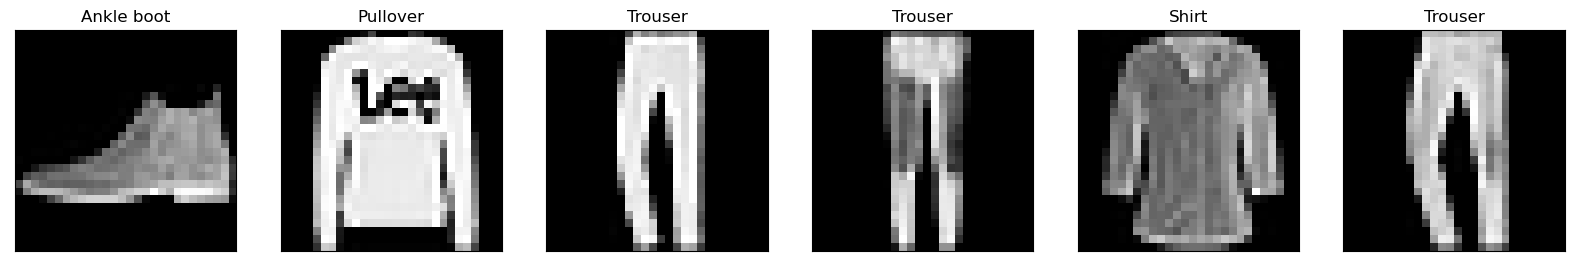

In [22]:
n = 6
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test[i])
    plt.title(classes[y_test[i]])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()
# plt.savefig("TrainingSet.png")

### Create Autoencoder

In [23]:
from tensorflow.keras.layers import Flatten, Conv2D, Dropout, MaxPooling2D, UpSampling2D, Input

In [24]:
from tensorflow.keras import Model

In [25]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

In [26]:
Model(input_img, encoded).summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0   

In [27]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [28]:
from tensorflow.keras.callbacks import TensorBoard

In [29]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/50
469/469 [==============================] - 54s 113ms/step - loss: 0.4282 - val_loss: 0.3089
Epoch 2/50
469/469 [==============================] - 54s 114ms/step - loss: 0.3050 - val_loss: 0.3014
Epoch 3/50
469/469 [==============================] - 52s 111ms/step - loss: 0.2973 - val_loss: 0.2975
Epoch 4/50
469/469 [==============================] - 51s 109ms/step - loss: 0.2947 - val_loss: 0.2948
Epoch 5/50
469/469 [==============================] - 56s 120ms/step - loss: 0.2924 - val_loss: 0.2934
Epoch 6/50
469/469 [==============================] - 54s 115ms/step - loss: 0.2905 - val_loss: 0.2920
Epoch 7/50
469/469 [==============================] - 57s 122ms/step - loss: 0.2900 - val_loss: 0.2906
Epoch 8/50
469/469 [==============================] - 56s 120ms/step - loss: 0.2888 - val_loss: 0.2897
Epoch 9/50
469/469 [==============================] - 55s 118ms/step - loss: 0.2882 - val_loss: 0.2888
Epoch 10/50
469/469 [==============================] - 53s 113ms/step - l

In [30]:
autoencoder.save("./data/Batch50.p")

INFO:tensorflow:Assets written to: ./data/Batch50.p\assets


In [31]:
from tensorflow.keras.models import load_model

In [32]:
autoencoder_first = load_model("./data/Batch50.p")

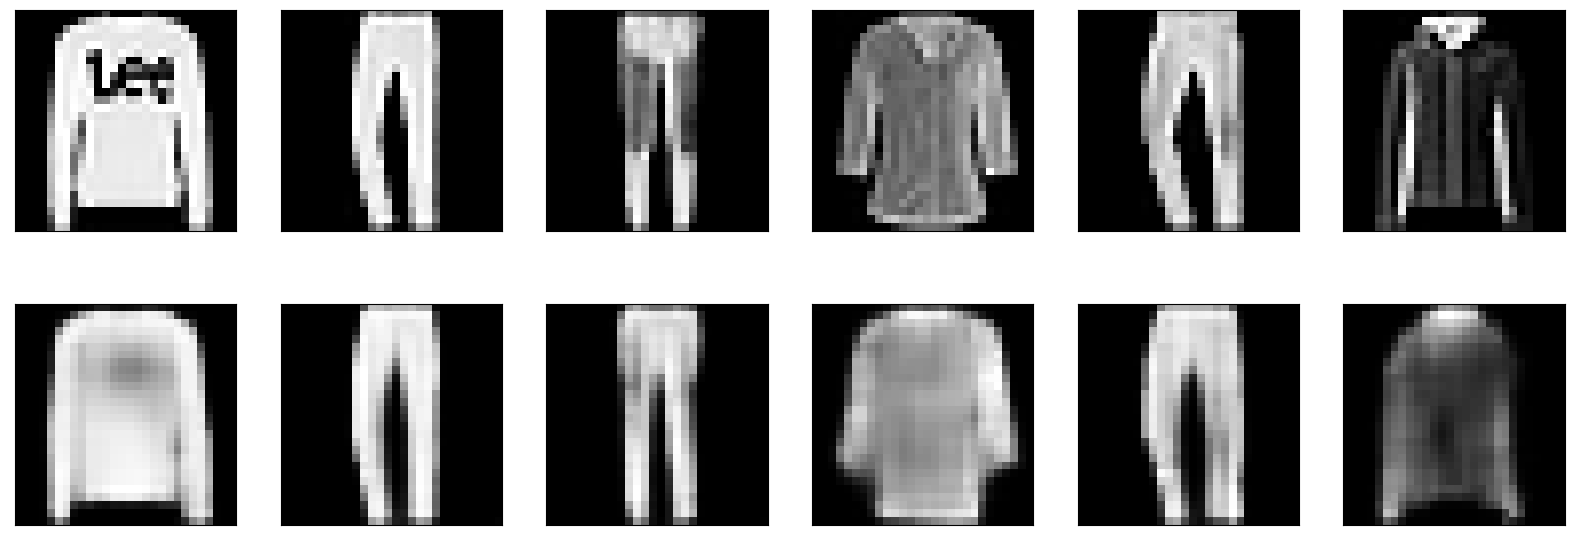

In [33]:
decoded_imgs = autoencoder_first.predict(x_test)

n = 6
plt.figure(figsize=(20, 7))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [34]:
from tensorflow.keras.optimizers import Adam

In [35]:
autoencoder.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy')

In [36]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/50
469/469 [==============================] - 52s 108ms/step - loss: 0.2801 - val_loss: 0.2803
Epoch 2/50
469/469 [==============================] - 49s 105ms/step - loss: 0.2784 - val_loss: 0.2803
Epoch 3/50
469/469 [==============================] - 50s 107ms/step - loss: 0.2779 - val_loss: 0.2802
Epoch 4/50
469/469 [==============================] - 49s 105ms/step - loss: 0.2781 - val_loss: 0.2802
Epoch 5/50
469/469 [==============================] - 49s 105ms/step - loss: 0.2782 - val_loss: 0.2802
Epoch 6/50
469/469 [==============================] - 49s 104ms/step - loss: 0.2780 - val_loss: 0.2801
Epoch 7/50
469/469 [==============================] - 49s 104ms/step - loss: 0.2782 - val_loss: 0.2801
Epoch 8/50
469/469 [==============================] - 50s 107ms/step - loss: 0.2780 - val_loss: 0.2800
Epoch 9/50
469/469 [==============================] - 49s 104ms/step - loss: 0.2778 - val_loss: 0.2800
Epoch 10/50
469/469 [==============================] - 50s 106ms/step - l

In [37]:
autoencoder.save("./data/Batch100.p")

INFO:tensorflow:Assets written to: ./data/Batch100.p\assets


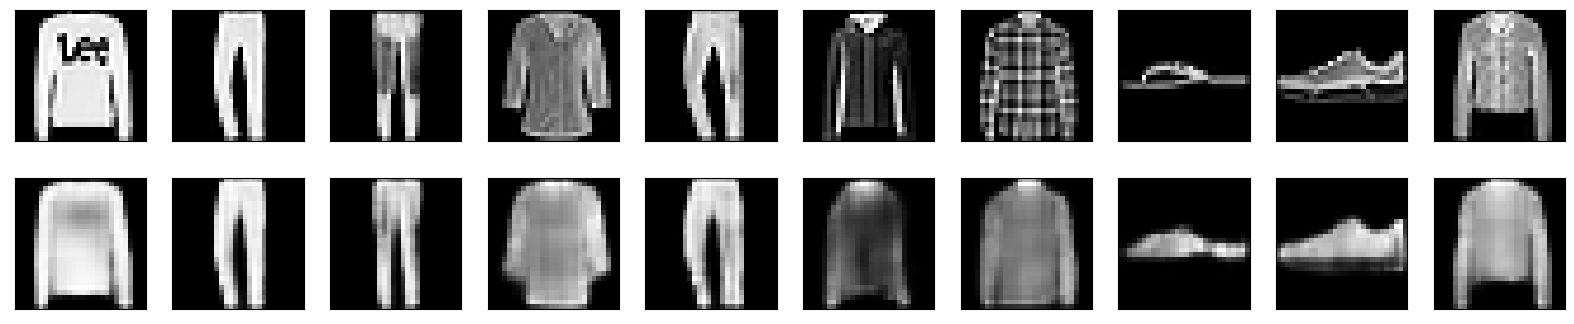

In [38]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Embeddings

We use the trained layers in order to get the core representation in the middle layer of the autoencoder, and we represent them with the TSNE

In [39]:
embeddings = Model(input_img, Flatten()(encoded)).predict(x_test)

In [40]:
from sklearn.manifold import TSNE
import numpy as np

In [41]:
tsne = TSNE(n_components=2)

In [42]:
emb2d = tsne.fit_transform(embeddings)

In [43]:
x,y = np.squeeze(emb2d[:, 0]), np.squeeze(emb2d[:, 1])

In [44]:
import pandas as pd

In [45]:
from matplotlib.cm import tab10

(-82.12278633117675, 87.6478946685791, -85.64047126770019, 102.01763038635254)

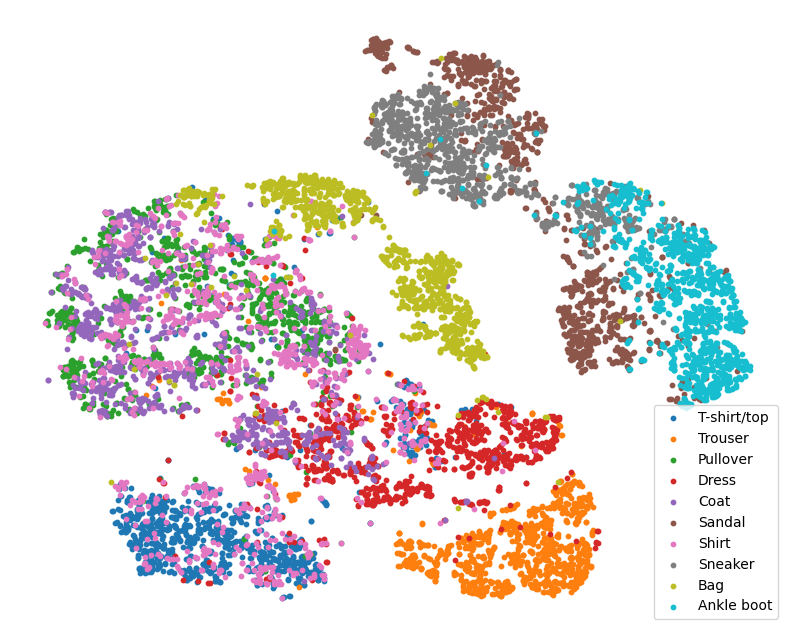

In [46]:
summary =  pd.DataFrame({"x": x, "y": y, "target": y_test, "size": 10})

plt.figure(figsize=(10,8))

for key, sel in summary.groupby("target"):
    plt.scatter(sel["x"], sel["y"], s=10, color=tab10.colors[key], label=classes[key])
    
plt.legend()
plt.axis("off")

### Denoising

Introducing noise in order to train more robust auto-encoders

In [47]:
from tensorflow.keras.layers import GaussianNoise

In [48]:
input_img = Input(shape=(28, 28, 1))

noisy_input = GaussianNoise(0.1)(input_img)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(noisy_input)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

noisy_autoencoder = Model(input_img, decoded)

In [49]:
noisy_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [50]:
noisy_autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/noisy_autoencoder')])

Epoch 1/50
469/469 [==============================] - 51s 106ms/step - loss: 0.4568 - val_loss: 0.3133
Epoch 2/50
469/469 [==============================] - 50s 106ms/step - loss: 0.3085 - val_loss: 0.3047
Epoch 3/50
469/469 [==============================] - 50s 106ms/step - loss: 0.3015 - val_loss: 0.3015
Epoch 4/50
469/469 [==============================] - 48s 103ms/step - loss: 0.2977 - val_loss: 0.2975
Epoch 5/50
469/469 [==============================] - 50s 107ms/step - loss: 0.2956 - val_loss: 0.2959
Epoch 6/50
469/469 [==============================] - 51s 109ms/step - loss: 0.2933 - val_loss: 0.2942
Epoch 7/50
469/469 [==============================] - 50s 108ms/step - loss: 0.2925 - val_loss: 0.2928
Epoch 8/50
469/469 [==============================] - 51s 109ms/step - loss: 0.2909 - val_loss: 0.2921
Epoch 9/50
469/469 [==============================] - 52s 110ms/step - loss: 0.2911 - val_loss: 0.2912
Epoch 10/50
469/469 [==============================] - 50s 106ms/step - l

In [51]:
autoencoder.save("./data/DenoisingAutoencoder.p")

INFO:tensorflow:Assets written to: ./data/DenoisingAutoencoder.p\assets


In [52]:
noise_factor = 0.1
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

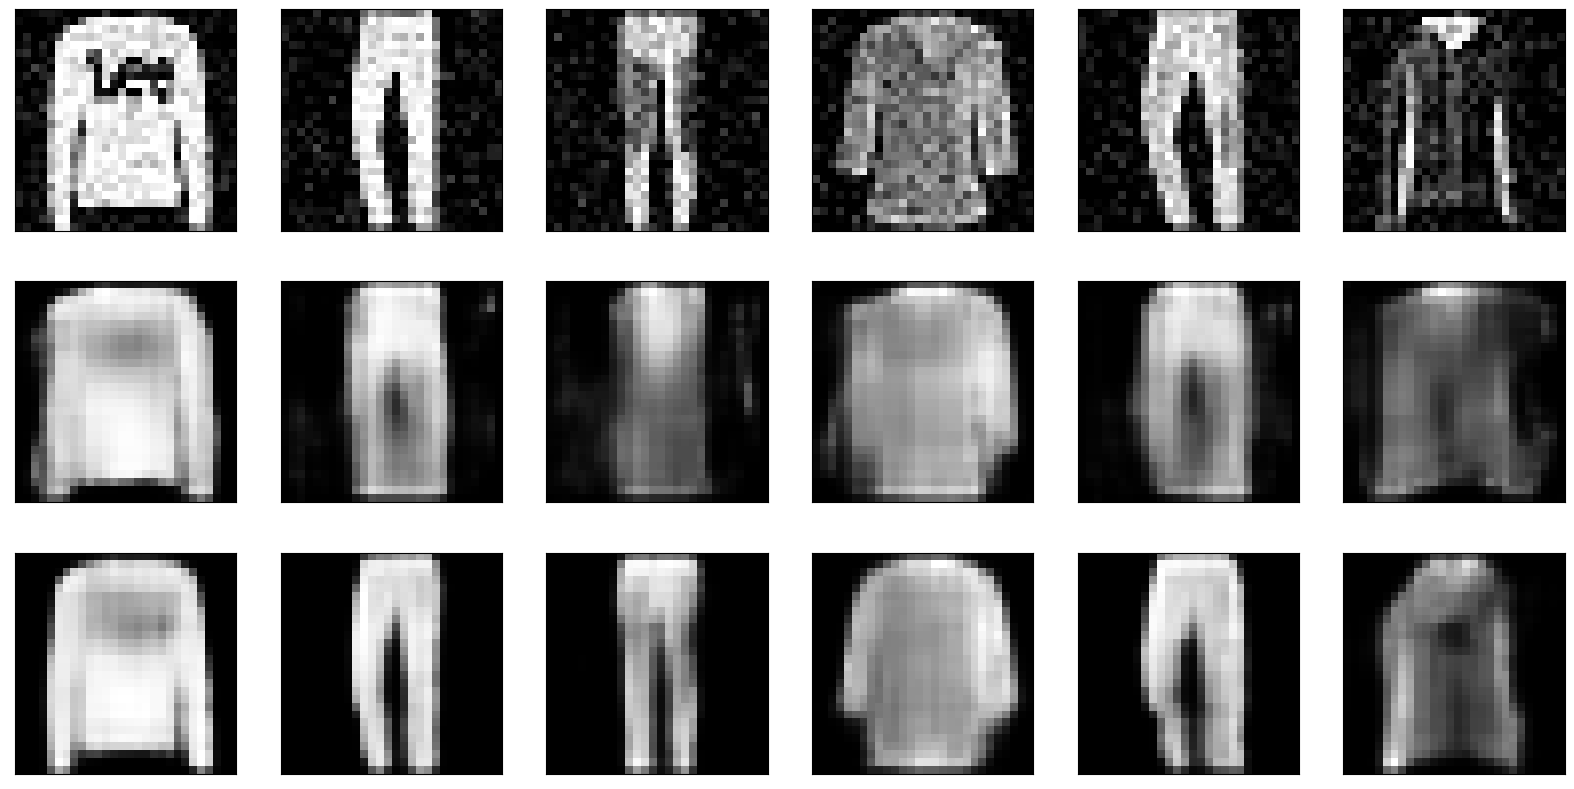

In [53]:
decoded_imgs = autoencoder.predict(x_test_noisy)

decoded_imgs_denoised = noisy_autoencoder.predict(x_test_noisy)

n = 6
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    if i==0:
        plt.ylabel("Original")
    else:
        ax.get_yaxis().set_visible(False)
        
    # Display reconstruction
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    if i==0:
        plt.ylabel("Vanilla Autoencoder")
    else:
        ax.get_yaxis().set_visible(False)
     
    ax = plt.subplot(3, n, i + 2*n)
    plt.imshow(decoded_imgs_denoised[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    if i==0:
        plt.ylabel("Denoising Autoencoder")
    else:
        ax.get_yaxis().set_visible(False)
    
        
plt.show()

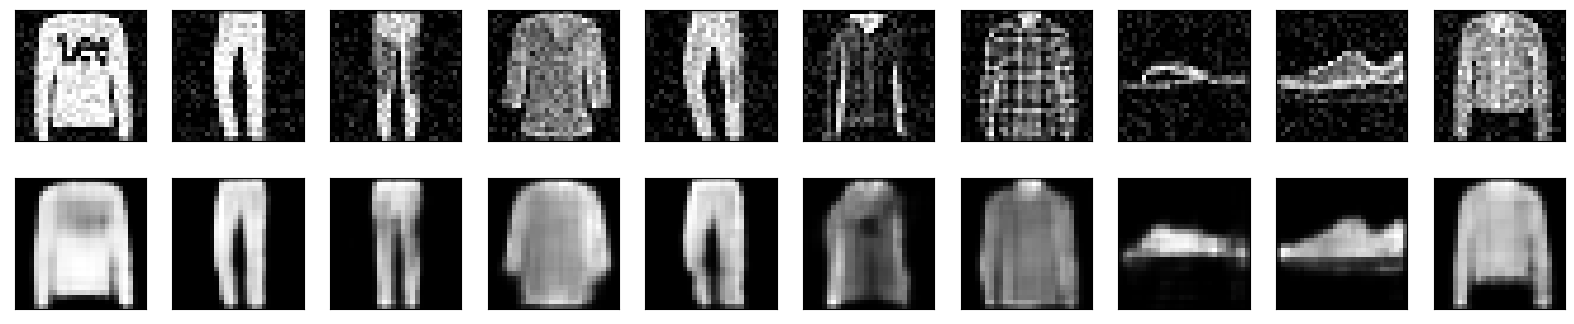

In [54]:
decoded_imgs = noisy_autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()